# Относительный порядок и нулевая динамика
## SISO системы
Для SISO систем понятие относительного порядка хорошо определено.
Пусть
$$
C A^0 B\\
C A^1 B\\
\dots\\
C A^{r - 1} B\\
$$
тогда $r$ называется относительным порядком. Если $r < n$, то в системе есть нулевая динамика.

In [155]:
using ControlSystems
using RobustAndOptimalControl
using LinearAlgebra
using Plots

In [156]:
n = 4
A = Float64[
    0 1 0 0
    0 0 1 0
    0 0 0 1
    -1 -2 -3 -1
]

4×4 Matrix{Float64}:
  0.0   1.0   0.0   0.0
  0.0   0.0   1.0   0.0
  0.0   0.0   0.0   1.0
 -1.0  -2.0  -3.0  -1.0

In [157]:
B = Float64[
    0
    0
    1
    1
]

4-element Vector{Float64}:
 0.0
 0.0
 1.0
 1.0

In [158]:
C = Float64[1 0 0 0]

1×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0

In [159]:
sys = ss(A, B, C, 0)

StateSpace{Continuous, Float64}
A = 
  0.0   1.0   0.0   0.0
  0.0   0.0   1.0   0.0
  0.0   0.0   0.0   1.0
 -1.0  -2.0  -3.0  -1.0
B = 
 0.0
 0.0
 1.0
 1.0
C = 
 1.0  0.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model

In [160]:
isstable(sys)

true

In [161]:
tsys = tf(sys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
2.220446049250313e-16s^3 - 8.881784197001252e-16s^2 + 0.9999999999999982s + 1.9999999999999991
----------------------------------------------------------------------------------------------
                            1.0s^4 + 1.0s^3 + 3.0s^2 + 2.0s + 1.0

Continuous-time transfer function model

In [162]:
CAnB = map(1:n) do r
    C * A^(r - 1) * B
end
@show CAnB
r = findfirst(!iszero, CAnB)

CAnB = [[0.0], [0.0], [1.0], [1.0]]


3

In [163]:
α = tsys.matrix[1].den.coeffs

5-element Vector{Float64}:
 1.0
 2.0
 3.0
 1.0
 1.0

In [164]:
β = tsys.matrix[1].num.coeffs

4-element Vector{Float64}:
  1.9999999999999991
  0.9999999999999982
 -8.881784197001252e-16
  2.220446049250313e-16

In [165]:
P = mapreduce(hcat, n:-1:1) do i
    A^(i - 1) * B
end

4×4 Matrix{Float64}:
  1.0   1.0   0.0  0.0
 -4.0   1.0   1.0  0.0
 -1.0  -4.0   1.0  1.0
 10.0  -1.0  -4.0  1.0

In [166]:
P = diagm(0 => fill(1, n), 1=>fill(α[end], n - 1), 2 => fill(α[end - 1], n - 2), 3 => fill(α[end - 2], n - 3))
P = P'
P = reverse(P, dims=2)

4×4 Matrix{Float64}:
 0.0  0.0  0.0  1.0
 0.0  0.0  1.0  1.0
 0.0  1.0  1.0  1.0
 1.0  1.0  1.0  3.0

In [167]:
round.(similarity_transform(sys, P).A; digits = 5)

4×4 Matrix{Float64}:
 -2.0  -5.0  -9.0  -14.0
  1.0   0.0   0.0    2.0
 -0.0   1.0  -0.0   -0.0
  0.0   0.0   1.0    1.0

In [168]:
similarity_transform(sys, P)

StateSpace{Continuous, Float64}
A = 
 -2.0                    -5.000000000000001       -9.0                     -14.0
  1.0                     0.0                      0.0                       2.0
 -2.220446049250313e-16   0.9999999999999994      -3.3306690738754696e-16   -7.771561172376096e-16
  5.551115123125783e-17   2.7755575615628914e-16   1.0                       1.0000000000000002
B = 
 -0.0
  1.0
  0.0
  0.0
C = 
 0.0  0.0  0.0  1.0
D = 
 0.0

Continuous-time state-space model

In [169]:
similarity_transform(sys, inv(P))

StateSpace{Continuous, Float64}
A = 
  3.999999999999999  -0.9999999999999998     -0.9999999999999999  -0.9999999999999999
  4.999999999999998  -0.9999999999999996     -0.9999999999999998  -0.9999999999999998
  3.999999999999999   2.220446049250313e-16  -0.9999999999999998  -0.9999999999999998
 11.999999999999996  -2.999999999999999      -1.9999999999999996  -2.9999999999999996
B = 
 0.9999999999999998
 1.9999999999999996
 1.9999999999999996
 3.999999999999999
C = 
 -2.0  0.0  -1.0  1.0
D = 
 0.0

Continuous-time state-space model

In [170]:
P = zeros(n, n)
P[1, :] = C
for i in 2:n
    p = P[i - 1:i - 1, :]
    P[i, :] = p * A + α[n - i + 2] * C
end
P

4×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0
 3.0  1.0  1.0  0.0
 2.0  3.0  1.0  1.0

In [171]:
function control_form(sys)
    A, B, C = sys.A, sys.B, sys.C
    n = size(A, 1)
    tsys = tf(sys)
    α = tsys.matrix[1].den.coeffs
    
    P = zeros(n, n)
    P[:, n] = B
    for i in n - 1:-1:1
        p = P[:, i + 1]
        P[:, i] = A * p + α[i + 1] * B
    end

    similarity_transform(sys, P), P
end

control_form (generic function with 1 method)

In [172]:
sys, P = control_form(sys)

(StateSpace{Continuous, Float64}
A = 
  0.0   1.0   2.7755575615628914e-17   0.0
  0.0   0.0   1.0                      0.0
  0.0   0.0   1.1102230246251565e-16   1.0
 -1.0  -2.0  -3.0                     -1.0
B = 
  0.0
  0.0
 -0.0
  1.0
C = 
 2.0  1.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model, [2.0 1.0 0.0 0.0; 0.0 2.0 1.0 0.0; 0.0 0.0 2.0 1.0; -1.0 -2.0 -3.0 1.0])

In [173]:
function relative_degree(sys)
    A, B, C = sys.A, sys.B, sys.C
    n = size(A, 1)
    findfirst(1:n) do r
        u_to_dy = C * A^(r - 1) * B
        !(u_to_dy[1] ≈ 0)
    end
end

relative_degree (generic function with 1 method)

In [174]:
relative_degree(sys)

3

In [175]:
function null_form(sys)
    sys, T = control_form(sys)
    n = size(A, 1)
    r = relative_degree(sys)
    P = diagm(0 => ones(n))
    for i in 1:n - r
        P[n - r + 1:end, :] += diagm(r, n, i - 1 => fill(sys.C[i], r))
    end
    P = inv(P)
    similarity_transform(sys, P), P, r
end

null_form (generic function with 1 method)

In [176]:
null_sys, null_P, r = null_form(sys)

(StateSpace{Continuous, Float64}
A = 
  -2.0  1.0   0.0  0.0
   0.0  0.0   1.0  0.0
   0.0  0.0   0.0  1.0
 -17.0  8.0  -5.0  1.0
B = 
 0.0
 0.0
 0.0
 1.0
C = 
 0.0  1.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model, [1.0 0.0 0.0 0.0; -2.0 1.0 0.0 0.0; 4.0 -2.0 1.0 0.0; -8.0 4.0 -2.0 1.0], 3)

In [177]:
isstable(null_sys)

true

In [360]:
control_form(sys)[1].C

1×4 Matrix{Float64}:
 2.0  1.0  0.0  0.0

In [219]:
function null_split(sys)
    null_sys, _, r = null_form(sys)
    A, B, C = null_sys.A, null_sys.B, null_sys.C
    n = size(A, 1)
    
    T = diagm(r, n, n - r => fill(1, r))
    pT = pinv(T)
    N = diagm(n - r, n, 0 => fill(1, n - r))
    pN = pinv(N)
    
    yA = T * A * pT
    yB = T * B
    yC = C * pT
    y_sys = ss(yA, yB, yC, 0)
    
    n_sys = ss(A[1:n - r, 1:n - r], [A[n - r, n - r + 1];;], A[n:n, 1:n - r], 0)
    
    y_sys, n_sys
end

null_split (generic function with 1 method)

In [220]:
reduced_sys, reduced_null_sys = null_split(null_sys)

(StateSpace{Continuous, Float64}
A = 
 0.0   1.0  0.0
 0.0   0.0  1.0
 8.0  -5.0  1.0
B = 
 0.0
 0.0
 1.0
C = 
 1.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model, StateSpace{Continuous, Float64}
A = 
 -2.0
B = 
 1.0
C = 
 -17.0
D = 
 0.0

Continuous-time state-space model)

In [221]:
L = kalman(reduced_sys, I, I)

3×1 Matrix{Float64}:
 3.3594140828612344
 5.142831490063222
 5.885153089926424

In [222]:
K = lqr(reduced_sys, I, I)

1×3 Matrix{Float64}:
 16.0623  2.06608  3.47632

In [223]:
reduced_sys

StateSpace{Continuous, Float64}
A = 
 0.0   1.0  0.0
 0.0   0.0  1.0
 8.0  -5.0  1.0
B = 
 0.0
 0.0
 1.0
C = 
 1.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model

In [224]:
controller = observer_controller(reduced_sys, K, L)

StateSpace{Continuous, Float64}
A = 
  -3.3594140828612344   1.0                 0.0
  -5.142831490063222    0.0                 1.0
 -13.947410838225869   -7.066076224882472  -2.4763183256127377
B = 
 3.3594140828612344
 5.142831490063222
 5.885153089926424
C = 
 16.062257748299444  2.0660762248824716  3.4763183256127377
D = 
 0.0

Continuous-time state-space model

In [225]:
feedback(reduced_sys, controller) |> poles

6-element Vector{ComplexF64}:
 -1.6882814127255892 + 0.0im
 -1.4458414443658607 + 0.0im
 -0.5152384406234302 + 2.3044954744626374im
 -0.5152384406234302 - 2.3044954744626374im
 -0.3355663350678263 + 2.35324283266905im
 -0.3355663350678263 - 2.35324283266905im

In [226]:
feedback(null_sys, controller) |> poles

7-element Vector{ComplexF64}:
  0.8275068681292759 + 2.0239385496134292im
  0.8275068681292759 - 2.0239385496134292im
 -0.6223348516174682 + 2.905657785139031im
 -0.6223348516174682 - 2.905657785139031im
 -2.9536821827938975 + 0.0im
 -2.1461971293518447 + 1.8711427534807181im
 -2.1461971293518447 - 1.8711427534807181im

In [227]:
feedback(reduced_sys, controller) 

StateSpace{Continuous, Float64}
A = 
 0.0                  1.0  0.0   -0.0                 -0.0                 -0.0
 0.0                  0.0  1.0   -0.0                 -0.0                 -0.0
 8.0                 -5.0  1.0  -16.062257748299444   -2.0660762248824716  -3.4763183256127377
 3.3594140828612344   0.0  0.0   -3.3594140828612344   1.0                  0.0
 5.142831490063222    0.0  0.0   -5.142831490063222    0.0                  1.0
 5.885153089926424    0.0  0.0  -13.947410838225869   -7.066076224882472   -2.4763183256127377
B = 
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
C = 
 1.0  0.0  0.0  0.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model

In [228]:
extended_sys = ExtendedStateSpace(reduced_sys)

ExtendedStateSpace{Continuous, Float64}
A = 
 0.0   1.0  0.0
 0.0   0.0  1.0
 8.0  -5.0  1.0
B1 = 
 0.0
 0.0
 1.0
B2 = 
 0.0
 0.0
 1.0
C1 = 
 1.0  0.0  0.0
C2 = 
 1.0  0.0  0.0
D11 = 
 0.0
D12 = 
 0.0
D21 = 
 0.0
D22 = 
 0.0
Continuous-time extended state-space model

In [229]:
hinfnorm2(reduced_sys)

(Inf, NaN)

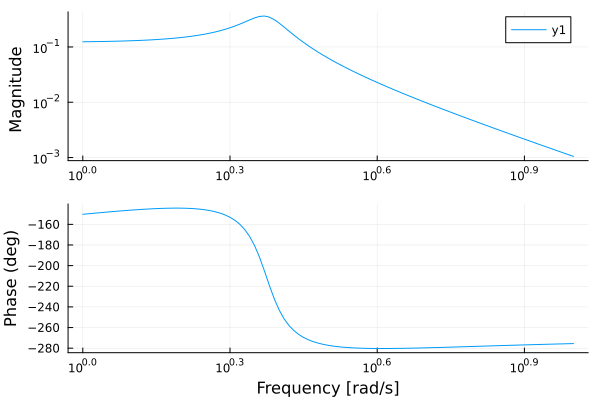

In [230]:
bodeplot(reduced_sys, exp10.(-0:0.01:1))

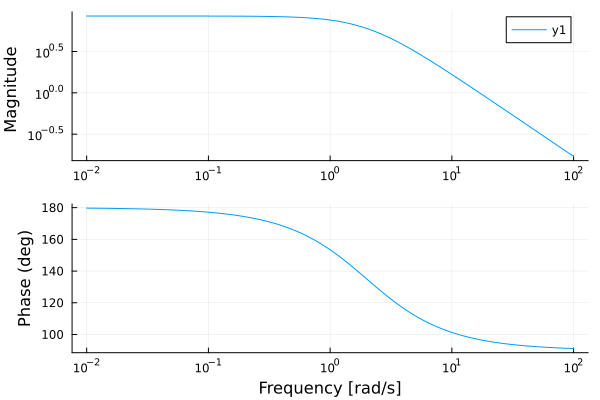

In [235]:
bodeplot(reduced_null_sys, exp10.(-2:0.01:2))

In [243]:
tf(reduced_sys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
            1.0
----------------------------
1.0s^3 - 1.0s^2 + 5.0s - 8.0

Continuous-time transfer function model

In [245]:
tf(reduced_null_sys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
  -17.0
----------
1.0s + 2.0

Continuous-time transfer function model

In [250]:
tf(null_sys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
             1.0s + 2.0
-------------------------------------
1.0s^4 + 1.0s^3 + 3.0s^2 + 2.0s + 1.0

Continuous-time transfer function model

In [256]:
feedback(reduced_sys, -reduced_null_sys) |> tf

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
2.220446049250313e-16s^3 + 1.3322676295501878e-15s^2 + 0.9999999999999991s + 1.9999999999999996
-----------------------------------------------------------------------------------------------
1.0s^4 + 1.0000000000000007s^3 + 3.000000000000004s^2 + 2.000000000000006s + 0.9999999999999988

Continuous-time transfer function model

In [255]:
feedback(reduced_sys, -reduced_null_sys) |> poles

4-element Vector{ComplexF64}:
 -0.1048766177403506 + 1.5524918200618771im
 -0.1048766177403506 - 1.5524918200618771im
 -0.3951233822596506 + 0.5068439018059824im
 -0.3951233822596506 - 0.5068439018059824im

In [257]:
null_sys |> poles

4-element Vector{ComplexF64}:
 -0.10487661774034981 + 1.5524918200618791im
 -0.10487661774034981 - 1.5524918200618791im
  -0.3951233822596501 + 0.5068439018059827im
  -0.3951233822596501 - 0.5068439018059827im

In [252]:
reduced_sys

StateSpace{Continuous, Float64}
A = 
 0.0   1.0  0.0
 0.0   0.0  1.0
 8.0  -5.0  1.0
B = 
 0.0
 0.0
 1.0
C = 
 1.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model

In [254]:
reduced_null_sys

StateSpace{Continuous, Float64}
A = 
 -2.0
B = 
 1.0
C = 
 -17.0
D = 
 0.0

Continuous-time state-space model

In [342]:
Ws = ss(1)

StateSpace{Continuous, Int64}
D = 
 1

Continuous-time state-space model

In [343]:
Wu = ss(1)

StateSpace{Continuous, Int64}
D = 
 1

Continuous-time state-space model

In [344]:
Wt = []

Any[]

In [345]:
h_sys = hinfpartition(reduced_sys, Ws, Wu, Wt)

ExtendedStateSpace{Continuous, Float64}
A = 
 0.0   1.0  0.0
 0.0   0.0  1.0
 8.0  -5.0  1.0
B1 = 
 0.0
 0.0
 0.0
B2 = 
 0.0
 0.0
 1.0
C1 = 
 -1.0  -0.0  -0.0
  0.0   0.0   0.0
C2 = 
 -1.0  -0.0  -0.0
D11 = 
 1.0
 0.0
D12 = 
 0.0
 1.0
D21 = 
 1.0
D22 = 
 -0.0
Continuous-time extended state-space model

In [346]:
K, y, mats = hinfsynthesize(h_sys)

(StateSpace{Continuous, Float64}
D = 
 0.0

Continuous-time state-space model, Inf, (X = Matrix{Float64}(undef, 0, 0), Y = Matrix{Float64}(undef, 0, 0), F = Matrix{Float64}(undef, 0, 0), H = Matrix{Float64}(undef, 0, 0), P̄ = ExtendedStateSpace{Continuous, Float64}
A = 
 0.0   1.0  0.0
 0.0   0.0  1.0
 8.0  -5.0  1.0
B1 = 
 0.0
 0.0
 0.0
B2 = 
  0.0
  0.0
 -1.0
C1 = 
 1.0  0.0  0.0
 0.0  0.0  0.0
C2 = 
 -1.0  -0.0  -0.0
D11 = 
 -1.0
  0.0
D12 = 
 0.0
 1.0
D21 = 
 1.0
D22 = 
 0.0
Continuous-time extended state-space model))

3×1 Matrix{Float64}:
  0.6384998137711644
  0.05335860782741226
 -0.373455488038031

1×3 Matrix{Float64}:
 0.460361  -0.247215  -1.49233

(Inf, NaN)

In [354]:
minimum(1:1000) do i
    K = randn(3, 1)
    L = randn(1, 3)
    a, b = observer_controller(reduced_sys, L, K) |> hinfnorm2
    a
end

3.1173466512782073

In [355]:
feedback(reduced_sys, controller) |> hinfnorm2

(1.4047968691146475, 2.2284062356923906)

In [356]:
ispassive(reduced_null_sys)

false

In [361]:
null_P

4×4 Matrix{Float64}:
  1.0   0.0   0.0  0.0
 -2.0   1.0   0.0  0.0
  4.0  -2.0   1.0  0.0
 -8.0   4.0  -2.0  1.0